In [1]:
!pip install torchsde

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [3]:
import numpy as np
import torch
import torch.optim.swa_utils as swa_utils
import torchsde
import tqdm

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (5, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class LipSwish(torch.nn.Module):
    def forward(self, x):
        return 0.909 * torch.nn.functional.silu(x)

class MLP(torch.nn.Module):
    def __init__(self, in_size, out_size, mlp_size, num_layers, tanh):
        super().__init__()

        model = [torch.nn.Linear(in_size, mlp_size), LipSwish()]
        
        for _ in range(num_layers - 1):
            model.append(torch.nn.Linear(mlp_size, mlp_size))
            model.append(LipSwish())
        
        model.append(torch.nn.Linear(mlp_size, out_size))
       
        if tanh:
            model.append(torch.nn.Tanh())
       
        self._model = torch.nn.Sequential(*model)

    def forward(self, x):
        return self._model(x)

$$ z_t = z_0 + \int_0^t f_\theta(z_s) dX_s $$

parameters: At,Bt,σt

In [5]:
class SDEFunc(torch.nn.Module):
    sde_type = 'ito'
    noise_type = 'general'

    def __init__(self, hidden_size, mlp_size, num_layers, A_t, sigma_t, B_t):
        super().__init__()

        self.A_t, self.sigma_t, self.B_t = A_t, sigma_t, B_t

        self.hidden_size = hidden_size

        # self.f_theta = MLP(1 + hidden_size, hidden_size * 1, mlp_size, num_layers, tanh=True)

        self.h_theta = MLP(1 + hidden_size, 1, mlp_size, num_layers, tanh=True)

    def f_and_g(self, t, y):
        # t has shape ()
        # y has shape (batch_size, 1 + hidden_size) --- this is the augmented(input) variable (log_s, z)

        t = t.expand(y.size(0), 1)

        x = y[:,0].unsqueeze(1) # log(S)
        
        # z = y[:,1:] 
        
        tx = torch.cat([t, x], dim=1)
        
        h_tx = self.h_theta(tx) 

        # f_tz = self.f_theta(tz)
        # f_tz = 1e-8*self.f_theta(tz)
        stand = torch.tensor([1])
        stand_= stand.repeat(batch_size, 1)

        drift_x = (self.A_t*x + self.B_t*h_tx)
        # drift_z = f_tz*drift_x
        # drift = torch.cat([drift_x, drift_z], dim=1)

        diffusion_x = self.sigma_t*stand_.unsqueeze(1)
        # diffusion_z = f_tz*diffusion_x
        # diffusion = torch.cat([diffusion_x, diffusion_z], dim=1).view(x.shape[0], 1 + self.hidden_size, 1)
        
        return drift_x, diffusion_x

In [6]:
class SDE(torch.nn.Module):
    def __init__(self, hidden_size, mlp_size, num_layers, A_t, sigma_t, B_t, dt):
        super().__init__()
        # self.g_theta = MLP(1, hidden_size, mlp_size, num_layers, tanh=True)
        self._func = SDEFunc(hidden_size, mlp_size, num_layers, A_t, sigma_t, B_t)
        self.dt = dt

    def forward(self, x0, ts):
        # ts has shape (t_size,) and corresponds to the points we want to evaluate the SDE at.
        y0 = x0
        # y0 = torch.cat([x0, self.g_theta(x0)], dim=1)
    

        ys = torchsde.sdeint(self._func, y0, ts, method='euler', dt=self.dt, adaptive=False) 
    
        # normalize the data
        # y0_flat = ys[0].view(-1)
        # ys = (ys - y0_flat.mean()) / y0_flat.std()

        return ys.permute(1,0,2)

In [7]:
def results_plot(model, x0_batch, losses, controls, T, batch_size, len, v_list, a_list, times):

    ts_ = torch.linspace(0, T, len, device=device)
    t = ts_.repeat(batch_size, 1).unsqueeze(2)

    with torch.no_grad():

        generated_samples = model(x0_batch, ts_)

        t = ts_.expand(batch_size, len).unsqueeze(2)
        x = generated_samples[...,0].unsqueeze(2)
        # z = generated_samples[...,1:]  
        tx = torch.cat([t, x], dim=2)

        alpha = model._func.h_theta(tx).cpu().numpy() 
      
        fig, ax = plt.subplots(1,4,figsize=(24,4))
        for k in range(batch_size):
            ax[0].plot(x[k,:,0], alpha=0.1, c='red')
            ax[0].set_title('Process $X_t$')
            ax[1].plot(alpha[k,:,0], alpha=0.1, c='blue')
            ax[1].set_title('Control $A_t$')
        ax[2].plot(torch.tensor(losses).cpu().numpy())
        ax[2].plot(v_list, 'r--')
        ax[2].set_title(f'v(t=0, x={x0})')
        ax[3].plot(torch.tensor(controls).cpu().numpy())
        ax[3].plot(a_list, 'r--')
        ax[3].set_title(f'at time 0:control(t=0, x={x0})')
        plt.show()

In [8]:
# Architectural hyperparameters. 
hidden_size = 1
mlp_size = 1
num_layers = 2

# rescaling constants
scale_lift = 1e-8
scale_vec_fields = 1e-8
scale_readout_weight = 1e-8
scale_readout_bias = 1e0

# parameters of dynamics
sigma = 0.1
# those parameters can be vectors
A_t = 0
sigma_t = sigma
B_t = 1
Q_t = 0
Q_T = 1
R_t = 1
T = 0.1
dt = 0.001
# T = 1
# dt = 0.01

# Training hyperparameters. 
lr = 1e-2 
# lr = 1            
weight_decay = 1e-2 
batch_size = 500        
t_size = 100
t_size_test = 100
iterations = 10000 
iterations_per_print = 100
times = int(iterations/iterations_per_print)

In [9]:
model = SDE(hidden_size, mlp_size, num_layers, A_t, sigma_t, B_t, dt).to(device)

In [10]:
model

SDE(
  (_func): SDEFunc(
    (h_theta): MLP(
      (_model): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): LipSwish()
        (2): Linear(in_features=1, out_features=1, bias=True)
        (3): LipSwish()
        (4): Linear(in_features=1, out_features=1, bias=True)
        (5): Tanh()
      )
    )
  )
)

In [11]:
optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) 
# optimiser = torch.optim.Adadelta(model.parameters(), lr=lr, weight_decay=weight_decay) 
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=.999)
ts = torch.linspace(0, T, t_size, device=device)
losses = []
controls = []

  0%|                                                 | 0/10000 [00:00<?, ?it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.61 
 theoretical optimal control at time 0: -4.55


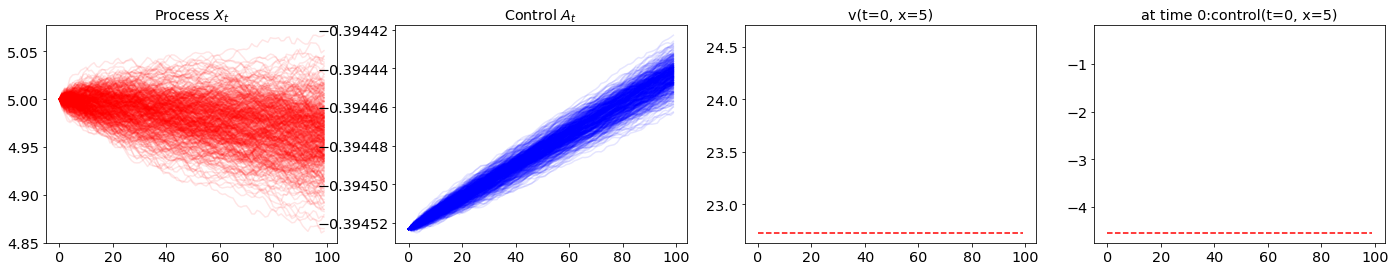

  1%|▍                                      | 100/10000 [00:08<12:08, 13.59it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.19 
 theoretical optimal control at time 0: -4.55


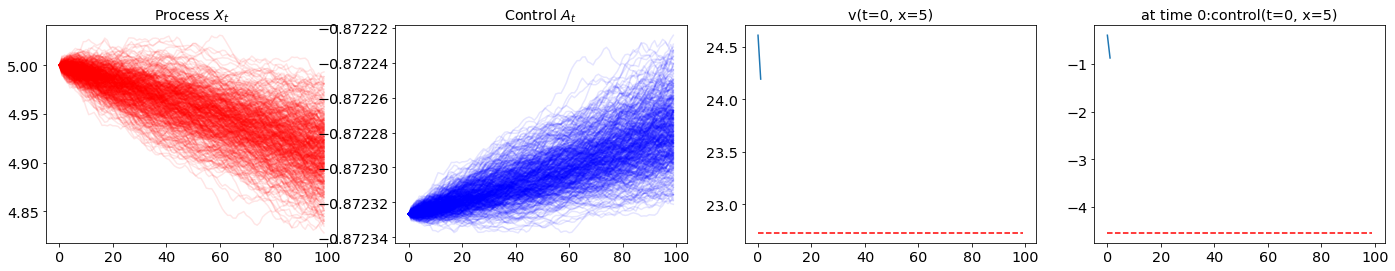

  2%|▊                                      | 200/10000 [00:17<12:02, 13.57it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.16 
 theoretical optimal control at time 0: -4.55


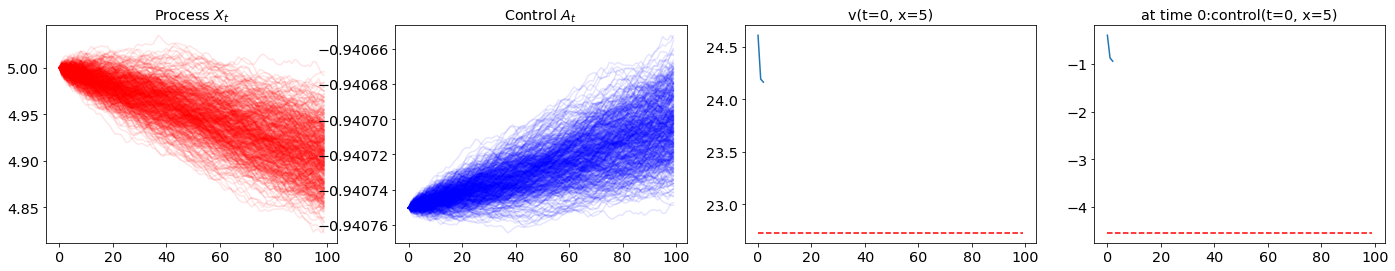

  3%|█▏                                     | 300/10000 [00:25<12:20, 13.09it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


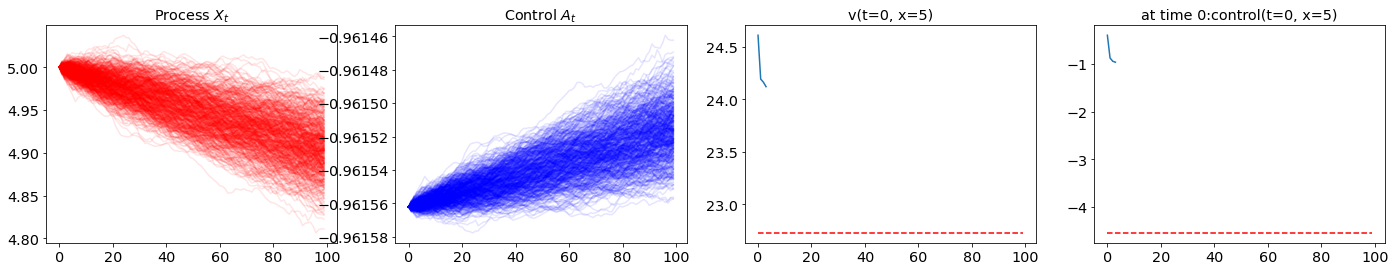

  4%|█▌                                     | 400/10000 [00:34<11:58, 13.36it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


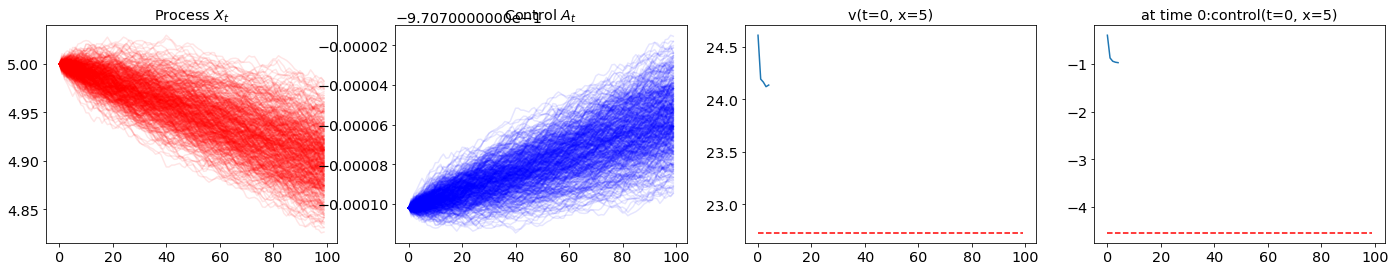

  5%|█▉                                     | 500/10000 [00:42<11:41, 13.55it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


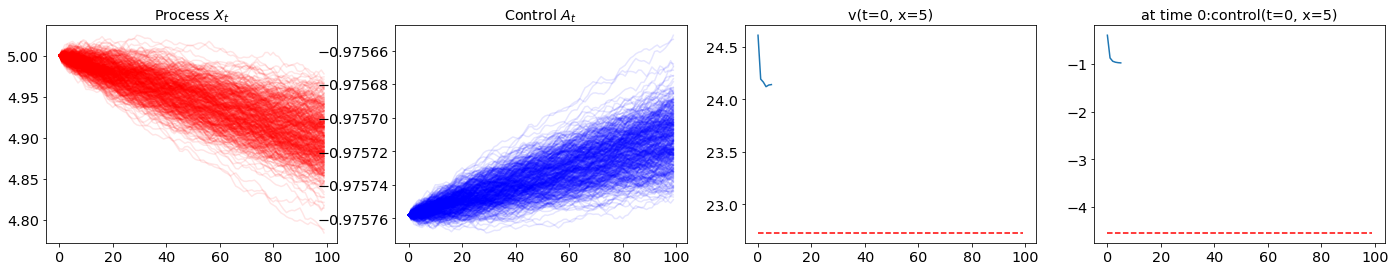

  6%|██▎                                    | 600/10000 [00:51<12:08, 12.90it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


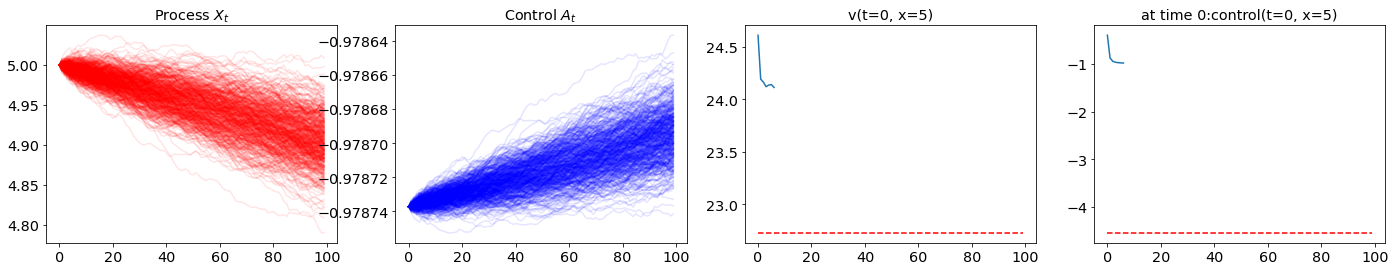

  7%|██▋                                    | 700/10000 [01:00<12:17, 12.62it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


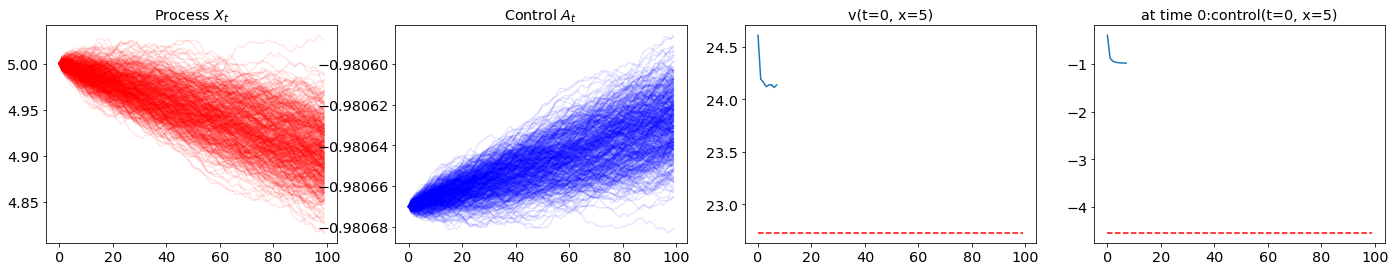

  8%|███                                    | 800/10000 [01:09<11:32, 13.28it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


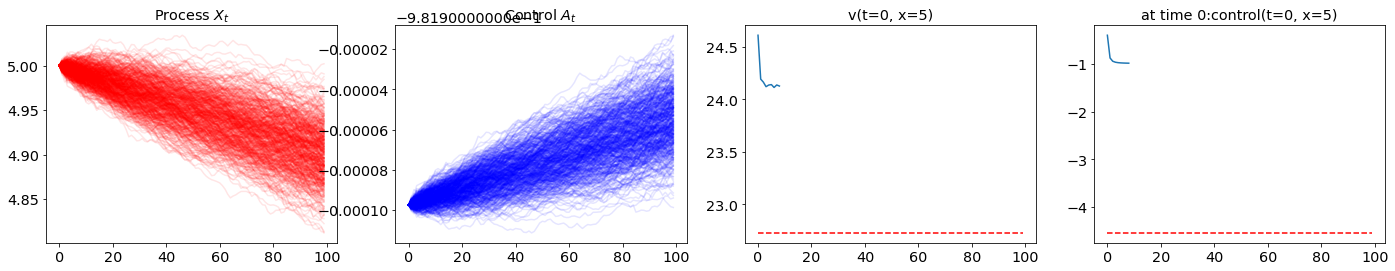

  9%|███▌                                   | 900/10000 [01:17<11:20, 13.38it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


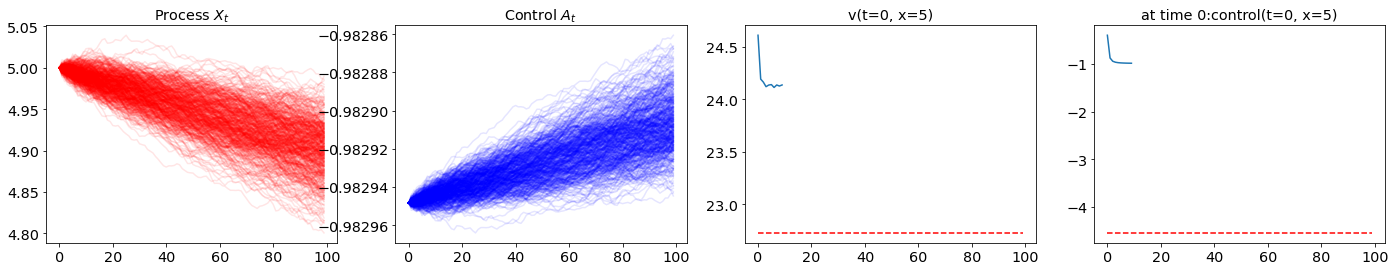

 10%|███▊                                  | 1000/10000 [01:26<11:00, 13.63it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


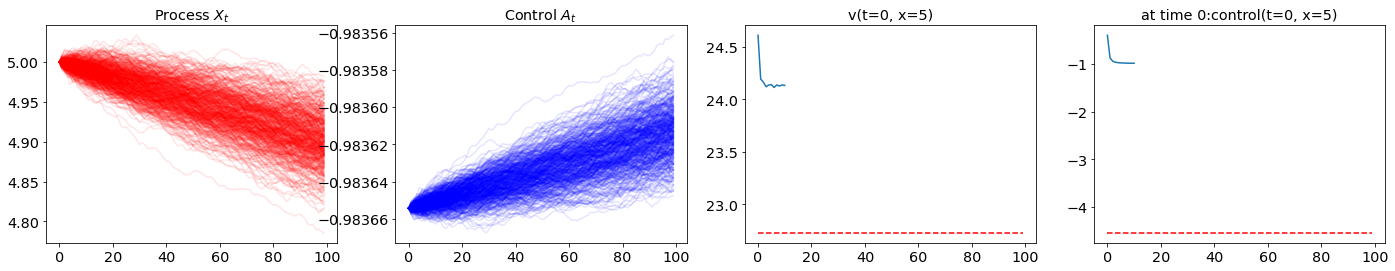

 11%|████▏                                 | 1100/10000 [01:34<10:57, 13.54it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.15 
 theoretical optimal control at time 0: -4.55


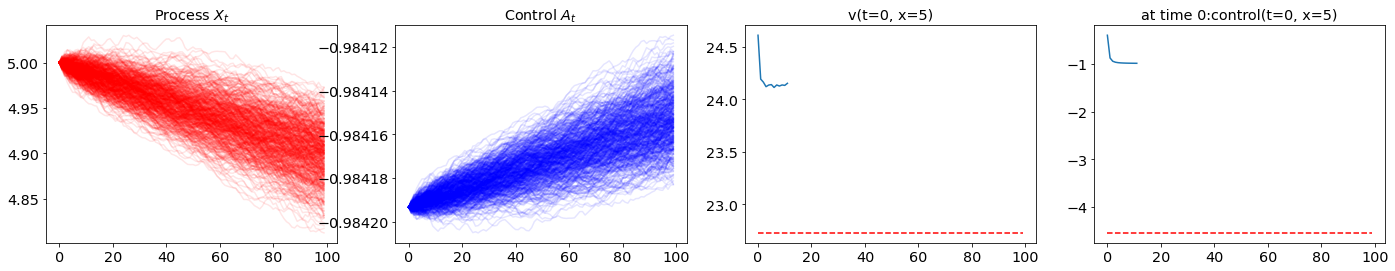

 12%|████▌                                 | 1200/10000 [01:42<10:39, 13.76it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


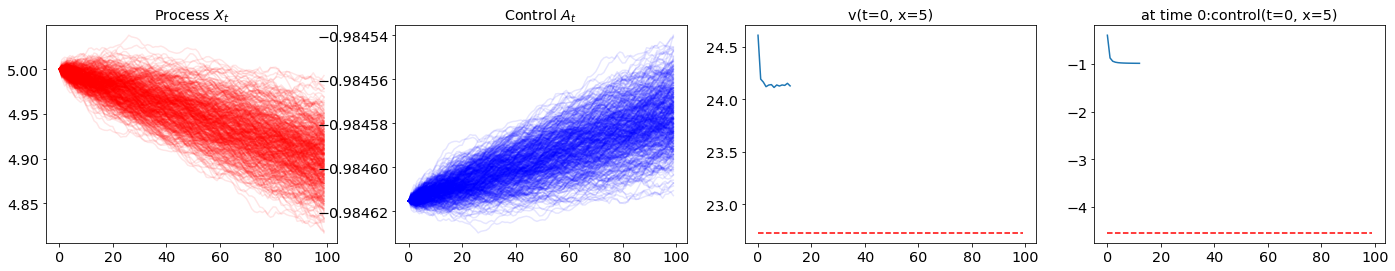

 13%|████▉                                 | 1300/10000 [01:51<10:33, 13.72it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


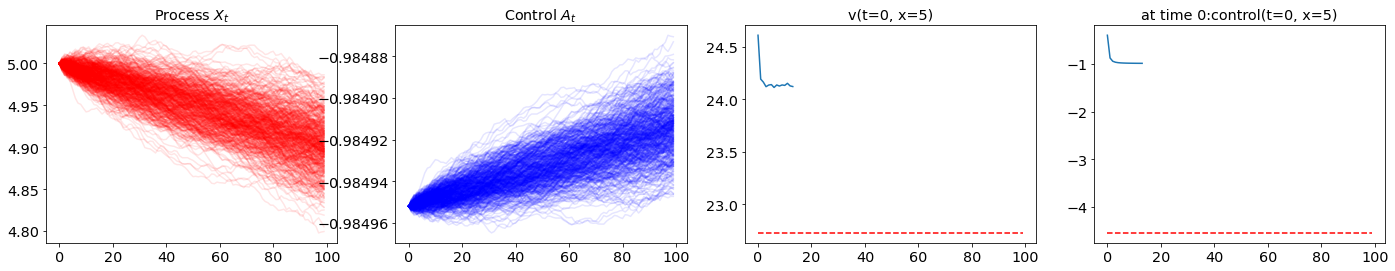

 14%|█████▎                                | 1400/10000 [01:59<10:38, 13.47it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


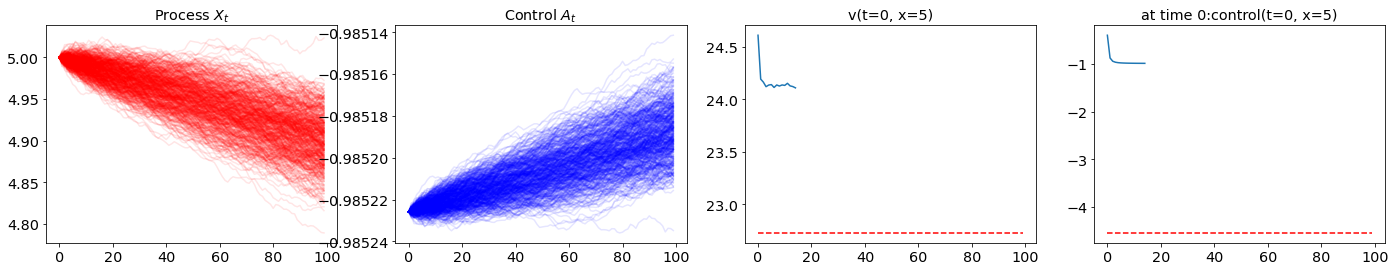

 15%|█████▋                                | 1500/10000 [02:08<10:18, 13.75it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


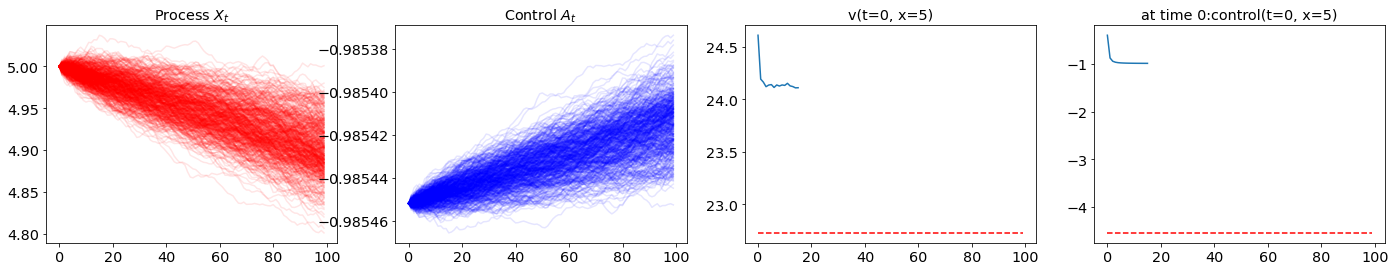

 16%|██████                                | 1600/10000 [02:16<10:12, 13.72it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


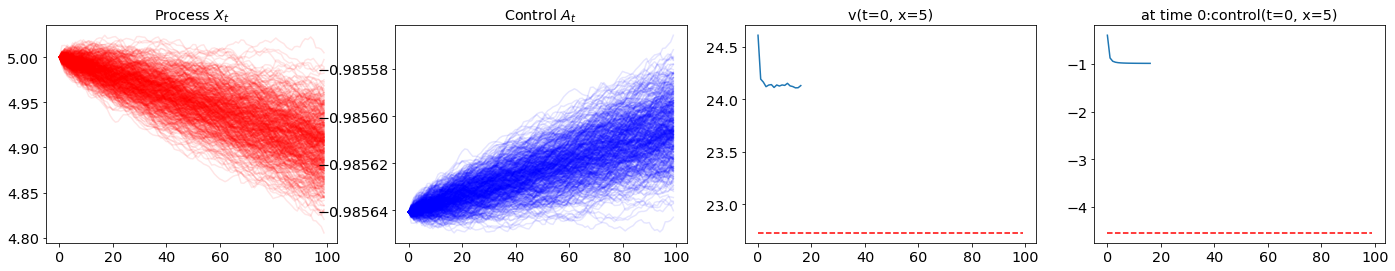

 17%|██████▍                               | 1700/10000 [02:24<10:08, 13.65it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


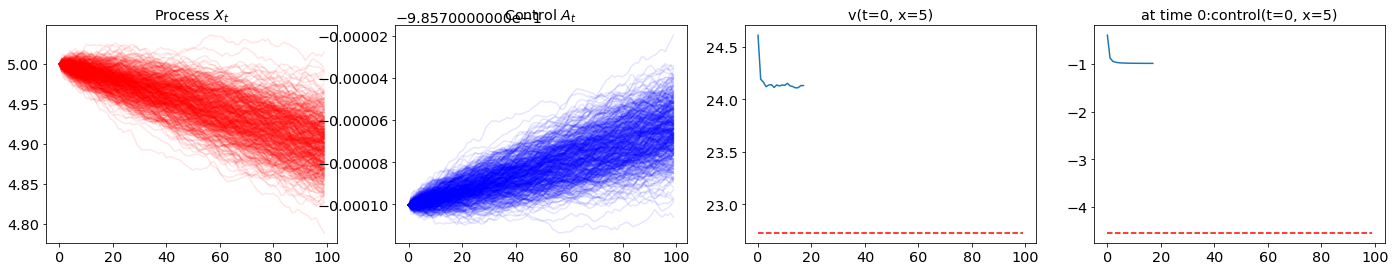

 18%|██████▊                               | 1800/10000 [02:33<09:53, 13.81it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


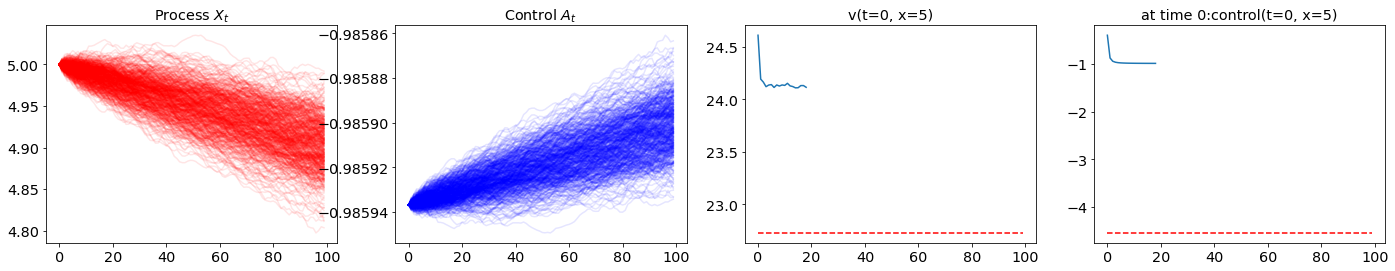

 19%|███████▏                              | 1900/10000 [02:41<10:11, 13.25it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


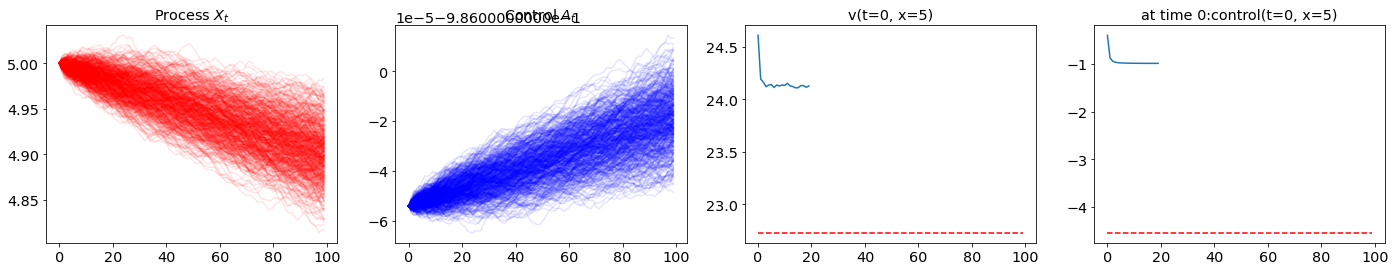

 20%|███████▌                              | 2000/10000 [02:50<10:04, 13.24it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


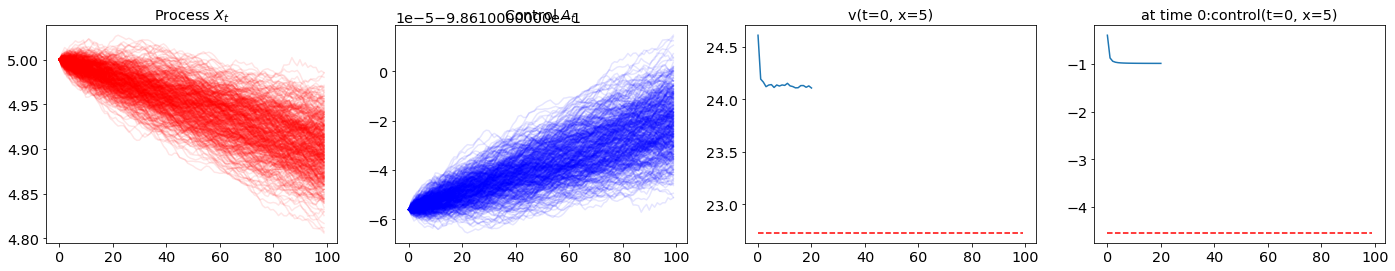

 21%|███████▉                              | 2100/10000 [02:58<09:59, 13.19it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


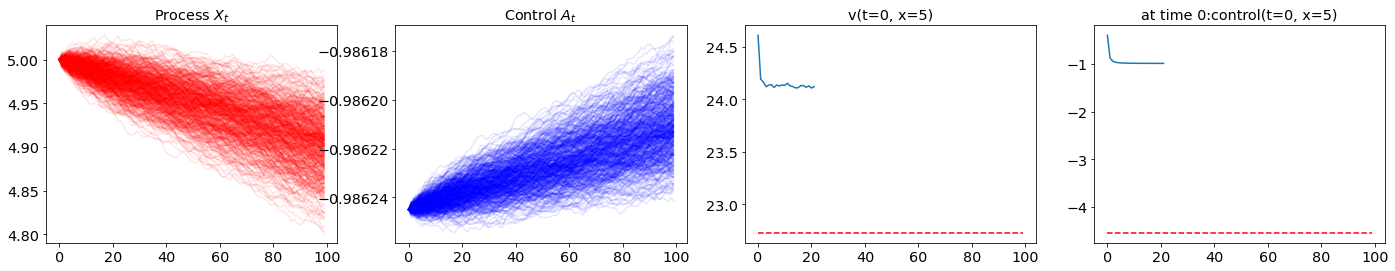

 22%|████████▎                             | 2200/10000 [03:07<09:53, 13.14it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


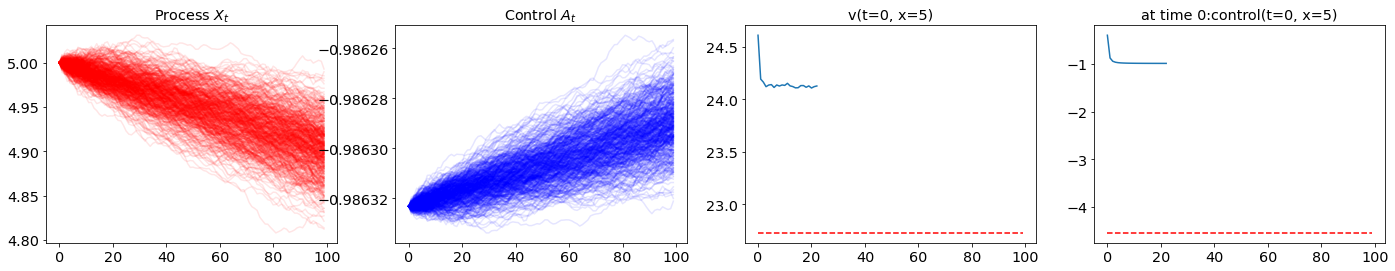

 23%|████████▋                             | 2300/10000 [03:16<09:20, 13.74it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


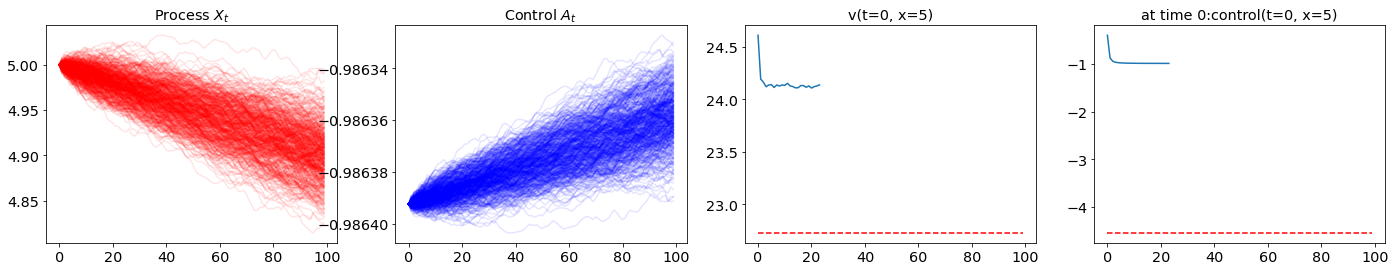

 24%|█████████                             | 2400/10000 [03:24<09:17, 13.64it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.1 
 theoretical optimal control at time 0: -4.55


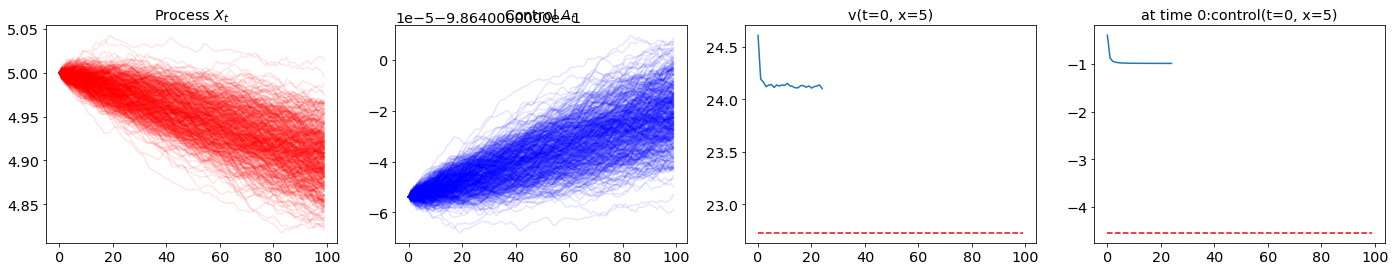

 25%|█████████▌                            | 2500/10000 [03:33<09:17, 13.45it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


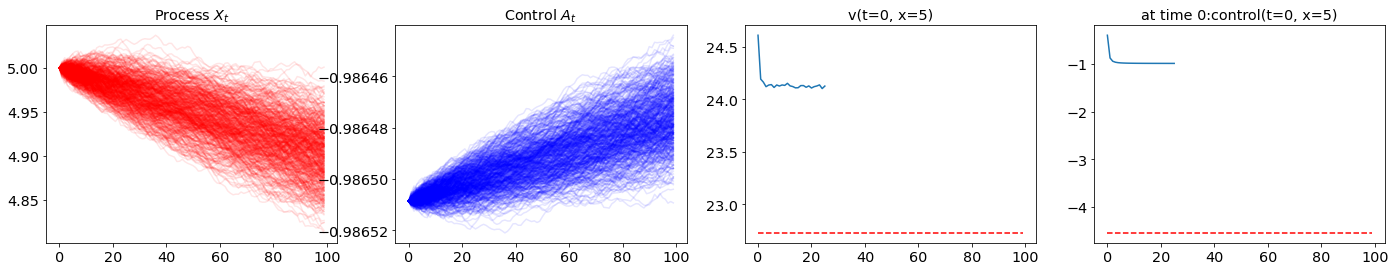

 26%|█████████▉                            | 2600/10000 [03:41<09:11, 13.42it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


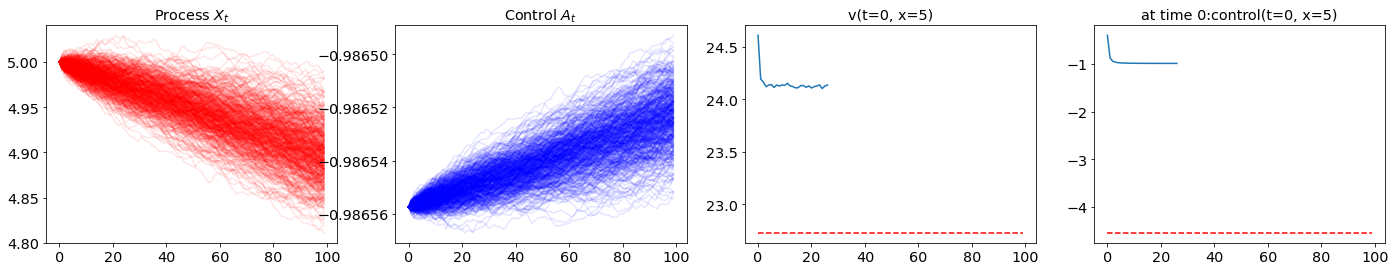

 27%|██████████▎                           | 2700/10000 [03:50<09:03, 13.43it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


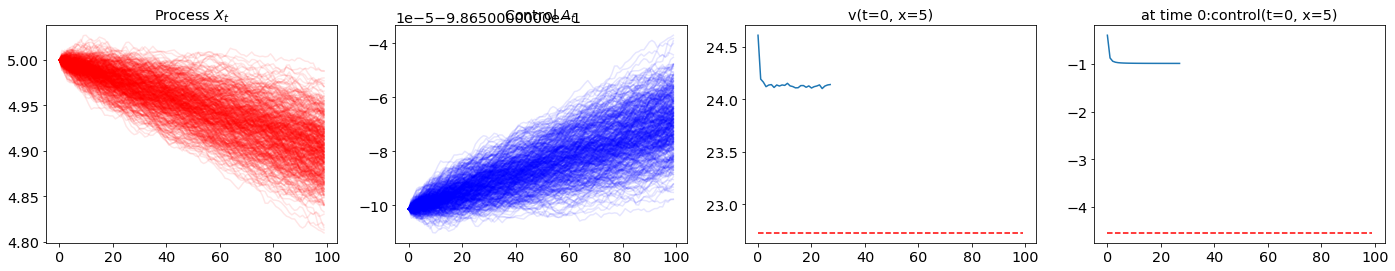

 28%|██████████▋                           | 2800/10000 [03:59<08:53, 13.49it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


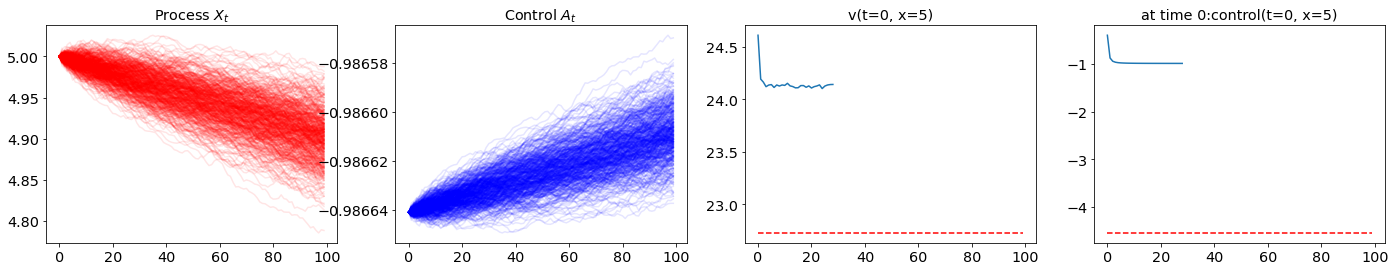

 29%|███████████                           | 2900/10000 [04:07<08:56, 13.24it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


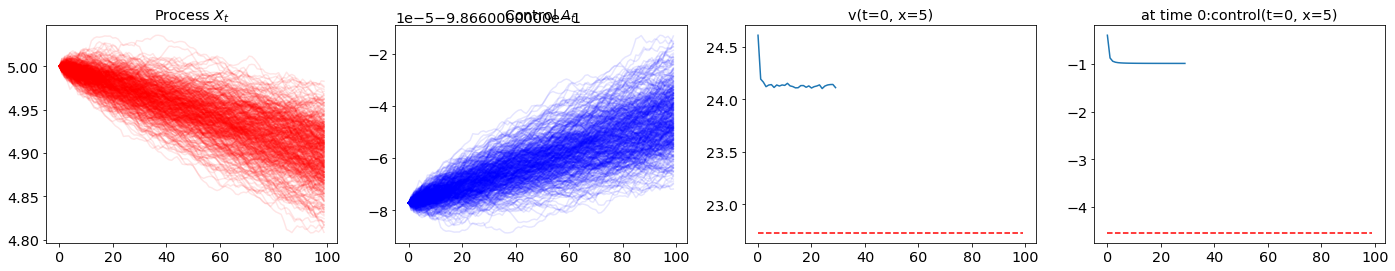

 30%|███████████▍                          | 3000/10000 [04:16<09:08, 12.76it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


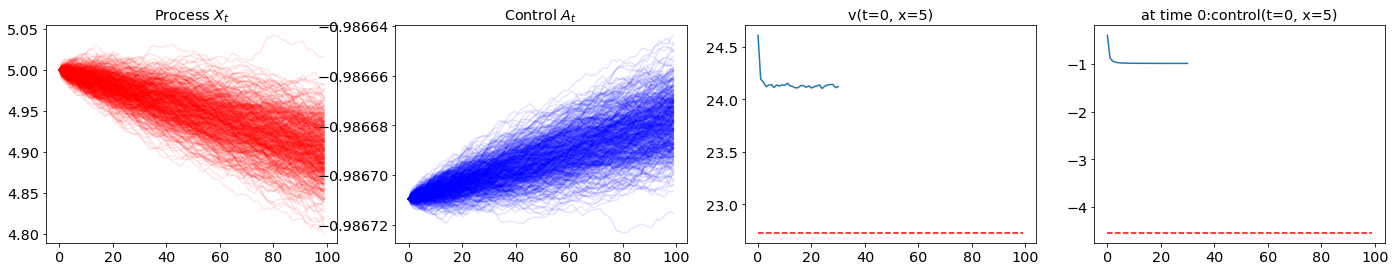

 31%|███████████▊                          | 3100/10000 [04:25<08:27, 13.59it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


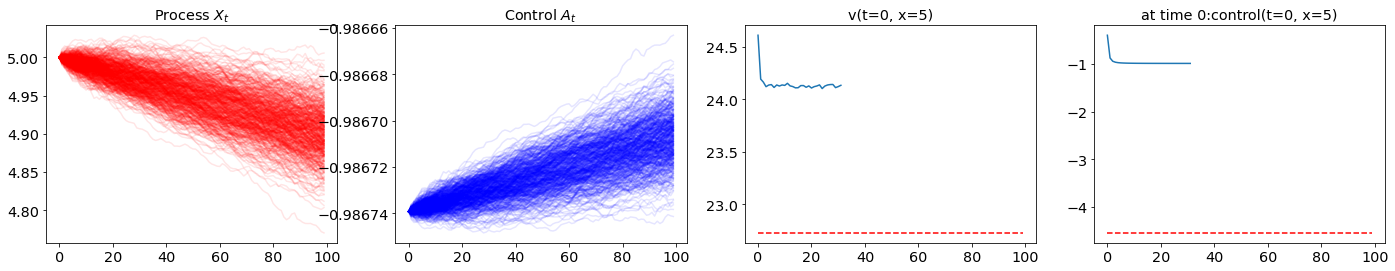

 32%|████████████▏                         | 3200/10000 [04:33<08:24, 13.49it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


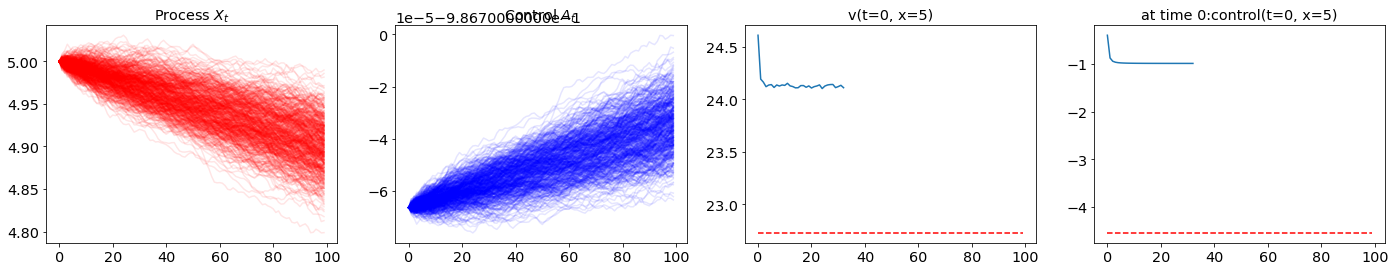

 33%|████████████▌                         | 3300/10000 [04:42<08:14, 13.55it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.1 
 theoretical optimal control at time 0: -4.55


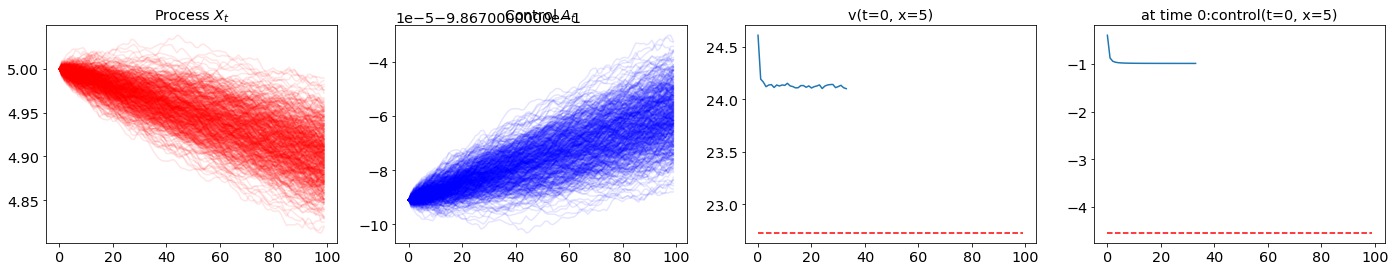

 34%|████████████▉                         | 3400/10000 [04:50<07:59, 13.77it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


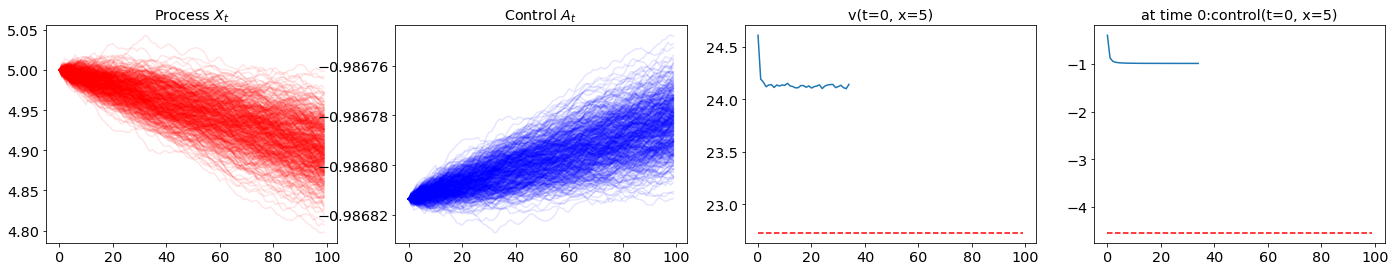

 35%|█████████████▎                        | 3500/10000 [04:59<08:07, 13.35it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


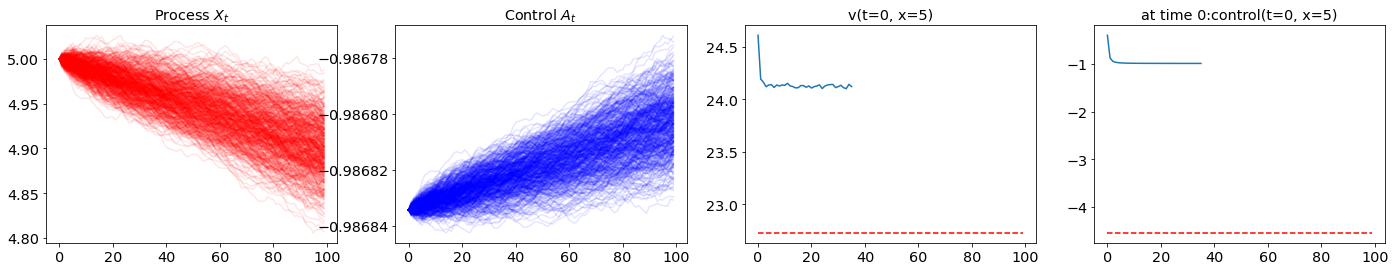

 36%|█████████████▋                        | 3600/10000 [05:07<08:09, 13.08it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


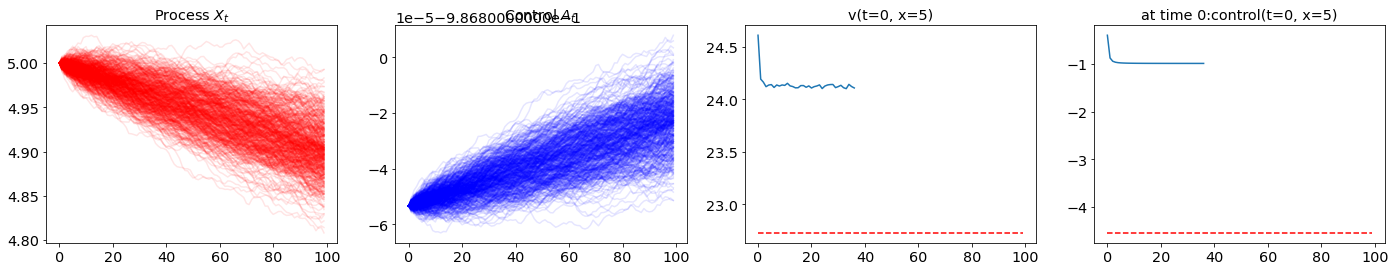

 37%|██████████████                        | 3700/10000 [05:16<08:04, 12.99it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


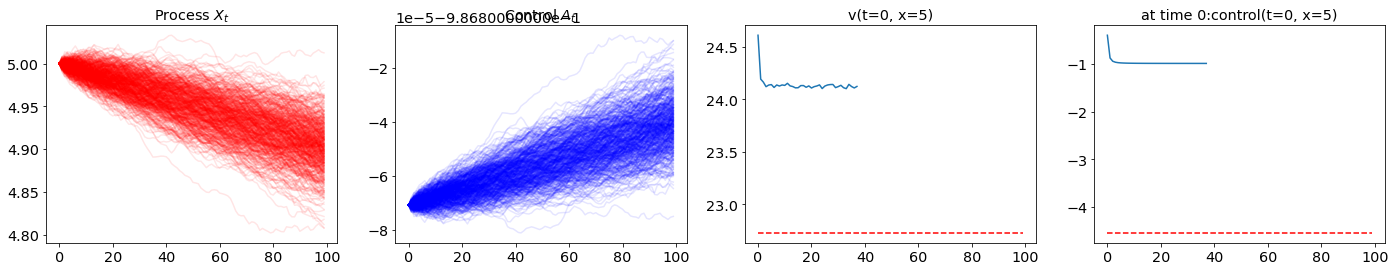

 38%|██████████████▍                       | 3800/10000 [05:25<07:45, 13.31it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


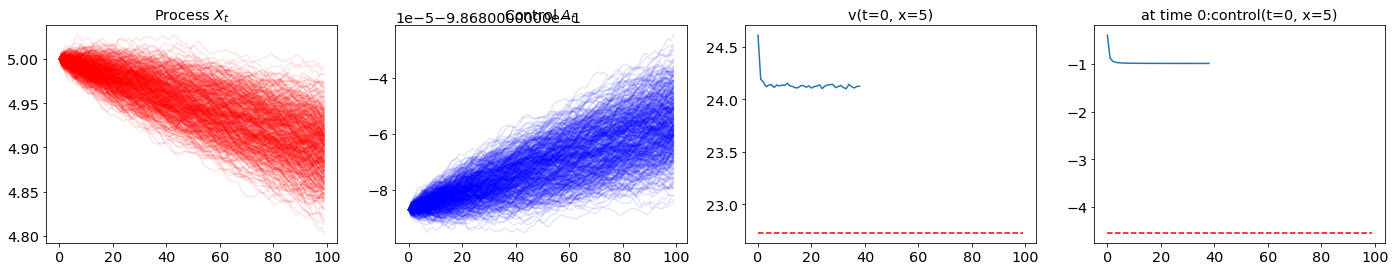

 39%|██████████████▊                       | 3900/10000 [05:34<07:34, 13.43it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


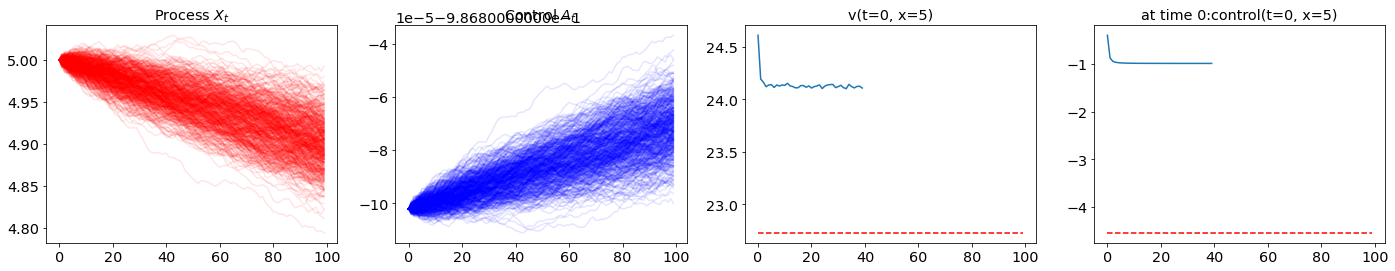

 40%|███████████████▏                      | 4000/10000 [05:43<07:54, 12.66it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.09 
 theoretical optimal control at time 0: -4.55


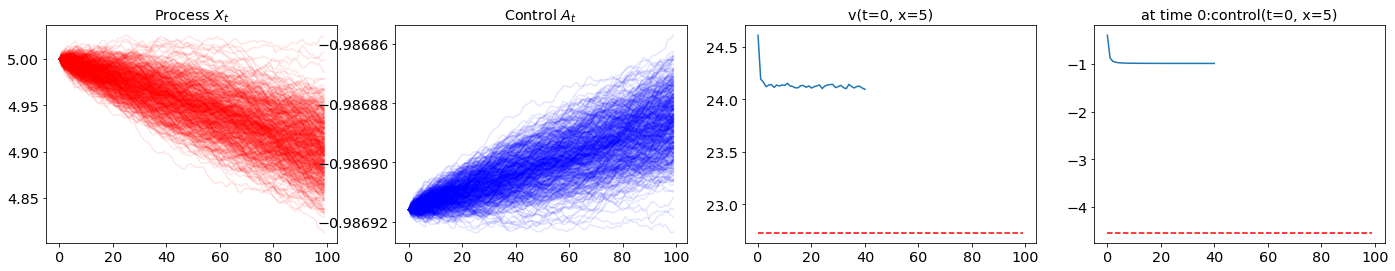

 41%|███████████████▌                      | 4100/10000 [05:51<07:37, 12.89it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.1 
 theoretical optimal control at time 0: -4.55


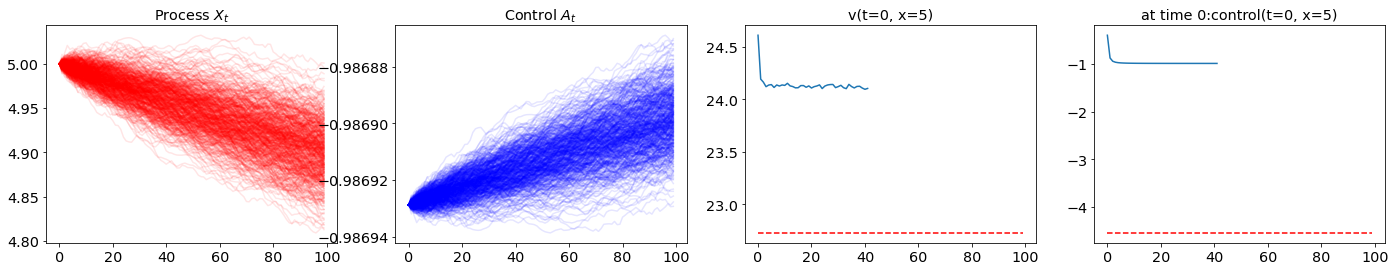

 42%|███████████████▉                      | 4200/10000 [06:00<07:25, 13.02it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.1 
 theoretical optimal control at time 0: -4.55


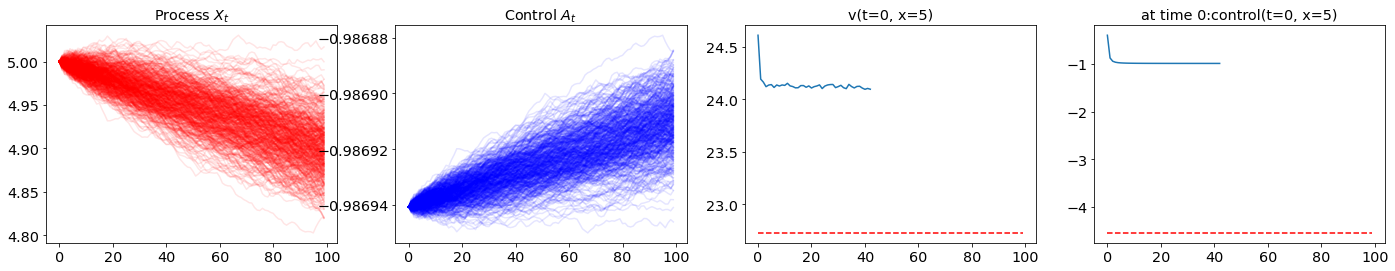

 43%|████████████████▎                     | 4300/10000 [06:09<06:57, 13.65it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


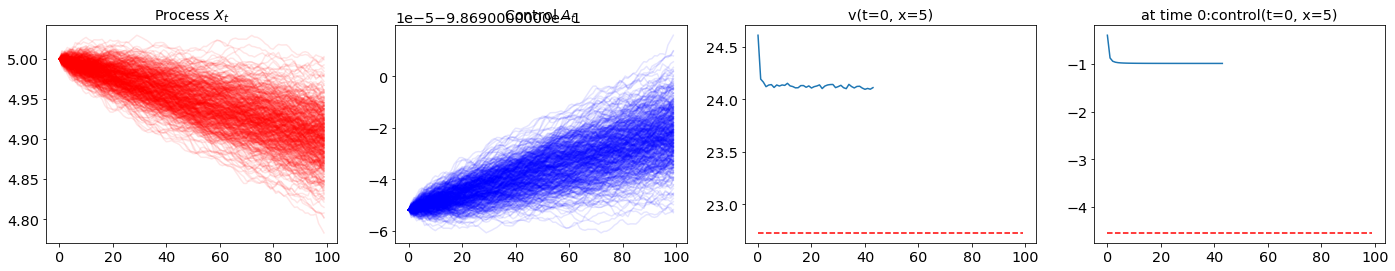

 44%|████████████████▋                     | 4400/10000 [06:18<07:15, 12.86it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


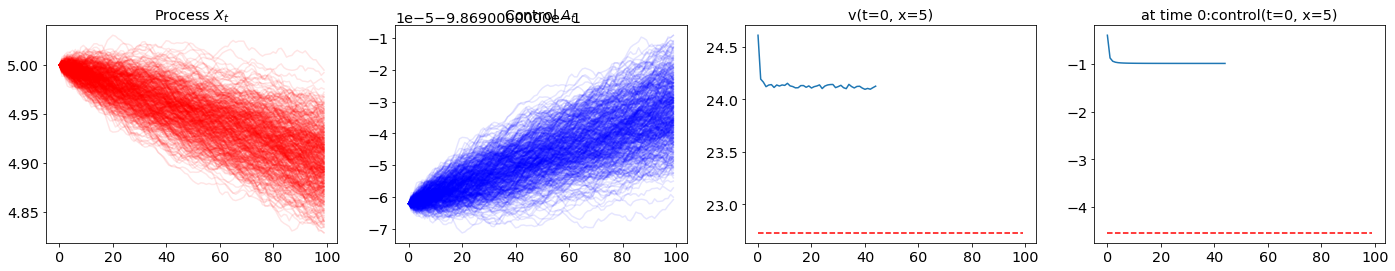

 45%|█████████████████                     | 4500/10000 [06:26<06:51, 13.36it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


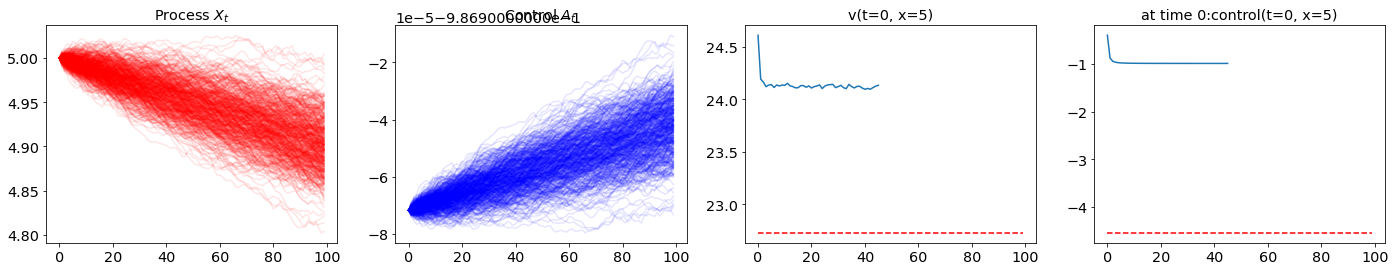

 46%|█████████████████▍                    | 4600/10000 [06:35<06:31, 13.81it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


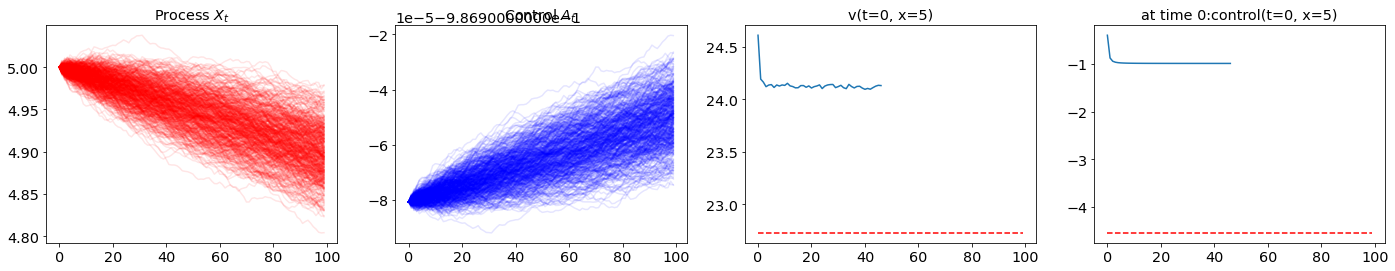

 47%|█████████████████▊                    | 4700/10000 [06:43<06:47, 13.01it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.1 
 theoretical optimal control at time 0: -4.55


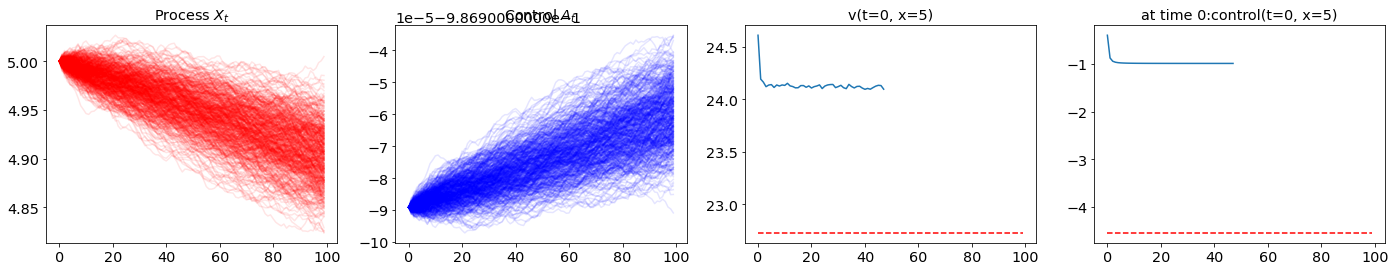

 48%|██████████████████▏                   | 4800/10000 [06:52<06:43, 12.90it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.1 
 theoretical optimal control at time 0: -4.55


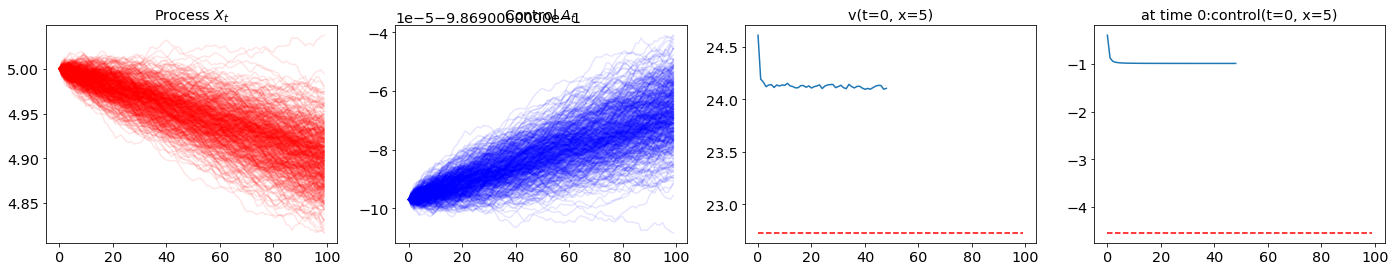

 49%|██████████████████▌                   | 4900/10000 [07:00<05:53, 14.45it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.13 
 theoretical optimal control at time 0: -4.55


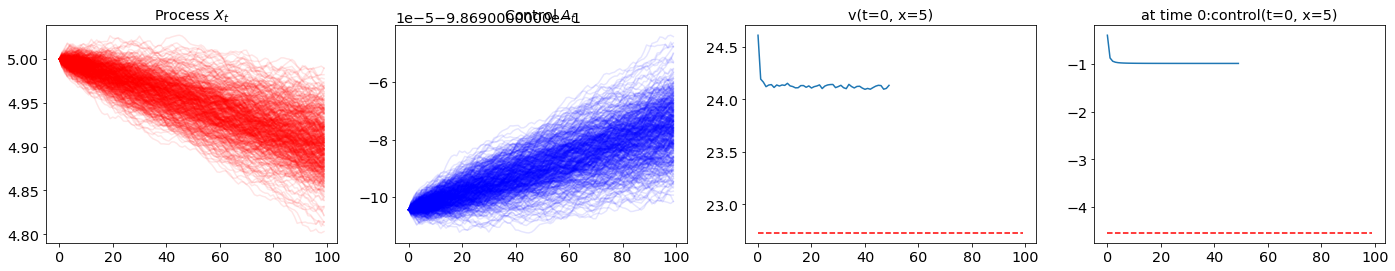

 50%|███████████████████                   | 5000/10000 [07:08<05:46, 14.42it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.09 
 theoretical optimal control at time 0: -4.55


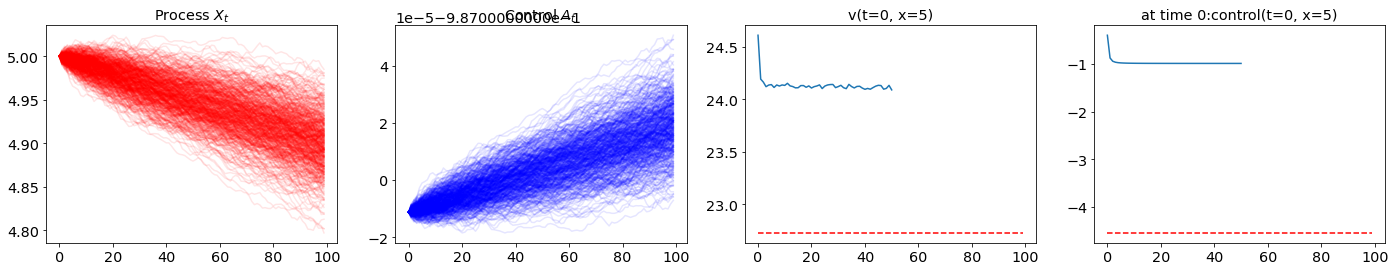

 51%|███████████████████▍                  | 5100/10000 [07:17<06:14, 13.09it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.11 
 theoretical optimal control at time 0: -4.55


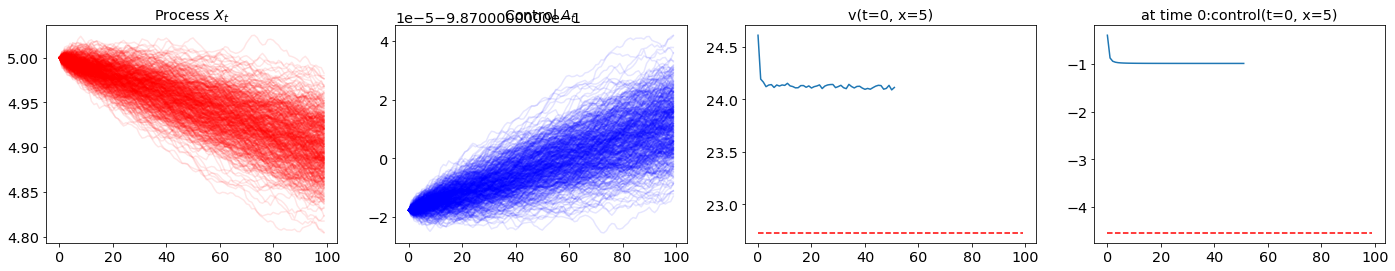

 52%|███████████████████▊                  | 5200/10000 [07:25<05:59, 13.36it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.14 
 theoretical optimal control at time 0: -4.55


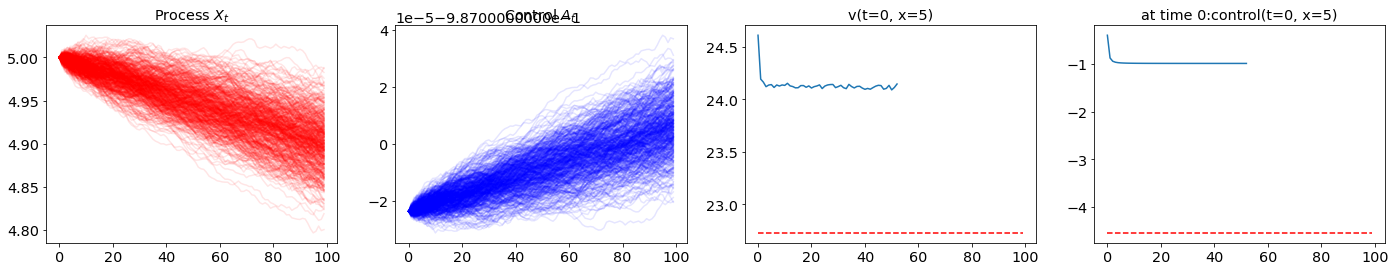

 53%|████████████████████▏                 | 5300/10000 [07:34<05:32, 14.13it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 24.12 
 theoretical optimal control at time 0: -4.55


In [ ]:
# training loop
trange = tqdm.tqdm(range(iterations))

for step in trange:

    #random initial condition
#     x0 = np.random.uniform(low=2, high=5)
    x0 = 5
    x0_batch = x0*torch.ones(batch_size, 1, device=device)

    optimiser.zero_grad()
    
    generated_samples = model(x0_batch, ts)
    t = ts.expand(batch_size, t_size).unsqueeze(2)

    x = generated_samples[...,0].unsqueeze(2)
    # z = generated_samples[...,1:]
    tx = torch.cat([t, x], dim=2)

    alpha = model._func.h_theta(tx)
    my_alpha = alpha.clone().detach()

    # print(f'size of x:{x.shape}')
    # print(f'size of alpha:{alpha.shape}')

    the_integral = torch.tensor(0).repeat(batch_size, 1)[:,0].float()
    for i in range(t_size):
      the_integral += (T/t_size)*(Q_t*x[:,i,0]*x[:,i,0] + R_t*my_alpha[:,i,0]*my_alpha[:,i,0])

    # could be in multi-dimensional 
    x_T = x[:,-1]
    loss = torch.mean(Q_T*x_T*x_T + the_integral)
    # print(loss)

    loss.backward()

    optimiser.step()
    
    scheduler.step()

    if (step % iterations_per_print) == 0 or step == iterations - 1:
        with torch.no_grad():

            # random initial condition
            # x0 = np.random.uniform(low=1.0, high=2.0)

            # theoretical optimal control and value function v(t=0,x=x_0)
            v = x0**2*Q_T/(Q_T*T+1) + sigma**2*np.log(Q_T*T+1)
      
            # calculate the theoretical optimal control at time = 0
            # P_t_star = []
            # for i in range(T/dt):
            #   P_t_star.append(Q_T/(Q_T*(T-i*dt)+1))
            # P_t_star = np.array(P_t_star)  
            P_0_star = Q_T/(Q_T*T+1)          
            K_t_star = R_t*B_t*P_0_star
            a_0_star = -K_t_star * x0


            x0_batch = x0*torch.ones(batch_size, 1, device=device)

            generated_samples = model(x0_batch, ts)
            t = ts.expand(batch_size, t_size).unsqueeze(2)

            x = generated_samples[...,0].unsqueeze(2)
            # z = generated_samples[...,1:]
            tx = torch.cat([t, x], dim=2)
            
            alpha = model._func.h_theta(tx).cpu().numpy()
            x_T = x[:,-1]
            the_integral = 0

            for i in range(t_size):
              the_integral += (T/t_size)*(Q_t*x[:,i,0]*x[:,i,0] + R_t*alpha[:,i,0]*alpha[:,i,0])
            
            # could be in multi-dimensional 
            loss = torch.mean(Q_T*x_T*x_T + the_integral)
#             print(alpha)
#             print(loss)
            v_theo = np.round(v,2)
            a_theo = np.round(a_0_star,2)

            # print the two theoretical solution line
            v_list = []
            a_list = []
            for i in range(times):
                v_list.append(v_theo)
                a_list.append(a_theo)
            
            print(f' \n initial condition: {np.round(x0,2)} \n',
                  f'theoretical value function: {v_theo} \n', 
                  f'predicted value function: {np.round(loss.cpu().numpy().item(),2)} \n',
                  f'theoretical optimal control at time 0: {a_theo}'
                  )
            alpha_0 = torch.mean(torch.tensor(alpha[:,0]))
            losses.append(loss)
            controls.append(alpha_0)

            results_plot(model, x0_batch, losses, controls, T, batch_size, t_size_test, v_list, a_list, times)

In [ ]:
controls